# Grenouille analysis with Swamp Optics dll

This notebook demonstrates running standard analysis of Grenouille temporal traces using the Swamp Optics FROG.dll. 

Note, the current version of FROG.dll that we have is for 32 bit architecture, which is antiquated. Rather than restrict the overall ImageAnalysis project to 32 bit python, we leverage the existance of a 32 bit python.exe. In the config.ini file located in ~.config/geecs_python_api/config.in, paths to both the FROG.dll and the 32 bit python executable need to be defined, e.g. 
```
[Paths]
frog_dll_path = Z:\software\FROG\FROG.dll
frog_python32_path = Z:\software\FROG\python-3.10.11-embed-win32\python.exe
```

In [1]:
# define paths to find configs and set up logging
from geecs_data_utils.scan_data import ScanData, ScanPaths
from geecs_data_utils.config_roots import image_analysis_config

import logging

logging.getLogger("image_analysis").setLevel(logging.WARNING)
logging.getLogger("geecs_data_utils").setLevel(logging.WARNING)


logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

image_analysis_config.set_base_dir(ScanPaths.paths_config.image_analysis_configs_path)

WindowsPath('//131.243.169.248/HDNA2/software/control-all-loasis/HTU/Active Version/GEECS-Plugins-Configs/image_analysis_configs')

This first section illustrates how to simply work directly with the algorithm starting with a preloaded image. We use a predefined config for "U_FROG_Grenouille-Temporal" to instantiate a BeamAnalyzer. Note, config can be used to implement various background subtractions, filtering, thresholding etc. It can use used a simple preprocessing step.

Here, we use the BeamAnalyzer to execute it's basic prepocessing and then store the image as gr_trace. The result is visualized for inspection

In [1]:
from pathlib import Path
import numpy as np

from image_analysis.offline_analyzers.beam_analyzer import BeamAnalyzer

dev_name = "U_FROG_Grenouille-Temporal"
file_path = Path('Z:/data/Undulator/Y2026/02-Feb/26_0210/scans/Scan015/U_FROG_Grenouille-Temporal/Scan015_U_FROG_Grenouille_050.png')

analyzer = BeamAnalyzer(camera_config_name='U_FROG_Grenouille-Temporal')
res = analyzer.analyze_image_file(file_path)
gr_trace = res.processed_image

analyzer.visualize(res)

ValueError: Failed to load camera configuration 'U_FROG_Grenouille-Temporal': config_dir is required (no global base dir set). Set IMAGE_ANALYSIS_CONFIG_DIR or pass config_dir explicitly.

With a loaded image, we can directly apply the retrieval algorithm. We start by importing the FrogDllRetrieval object. We instanatiate a retrieval object using a class method (.from-config()) that finds the paths to the proper dll file and the 32-bit python executable. Then, the retrieval is executed on the gr_trace and using the hardware specific calibration factors, and user defined parameters (e.g. grid size, target_error and max_time_seconds). Attributes that are generated by this retrieval are shown in comments.

In [ ]:
from image_analysis.algorithms.frog_dll_retrieval import FrogDllRetrieval
retrieval = FrogDllRetrieval.from_config()

result = retrieval.retrieve_pulse(
    # gr_trace, delt=0.89368, dellam=-0.0798546, lam0=400., N=512, target_error=.001, max_time_seconds=5
    gr_trace, delt=0.85, 
    dellam=-0.085, 
    lam0=400., 
    N=512, 
    target_error=.001, 
    max_time_seconds=5,
    max_iterations=1000

)

# # All outputs available:
# result.input_trace          # N×N gridded input
# result.retrieved_trace      # N×N simulated from retrieved pulse
# result.temporal_fwhm        # scalar
# result.spectral_fwhm        # scalar
# result.wavelength           # 1D axis
# result.spectral_intensity   # 1D
# result.spectral_phase       # 1D (radians)
# result.time                 # 1D axis
# result.temporal_intensity   # 1D
# result.temporal_phase       # 1D (radians)

Next, we can visualize the results comparing the initial trace to the retrieved trace. We define and use a color scale commonly used by labview apps at BELLA

NameError: name 'result' is not defined

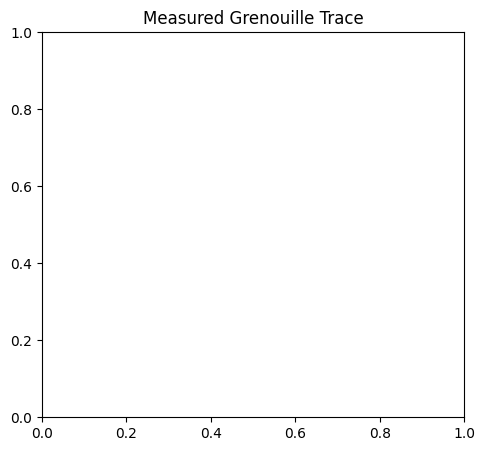

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormap
colors = [
    (1, 1, 1),   # white
    (0, 0, 1),   # blue
    (1, 0, 0)    # red
]

cmap_wbr = LinearSegmentedColormap.from_list("white_blue_red", colors)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title("Measured Grenouille Trace")
plt.imshow(np.flip(result.input_trace.T, axis=0), aspect='auto', origin='lower', cmap=cmap_wbr)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Reconstructed Trace")
plt.imshow(np.flip(result.retrieved_trace.T, axis=0), aspect='auto', origin='lower', cmap=cmap_wbr)
plt.colorbar()

plt.tight_layout()
plt.show()
print(f'FWHM of temporal slice [fs] {result.temporal_fwhm}')
print(f'FWHM of spectral slice [nm] {result.spectral_fwhm}')
print(f'Minimum frog error retrieved {result.frog_error}')

Other aspects of the retrieval are available for inspection, e.g spectral phase

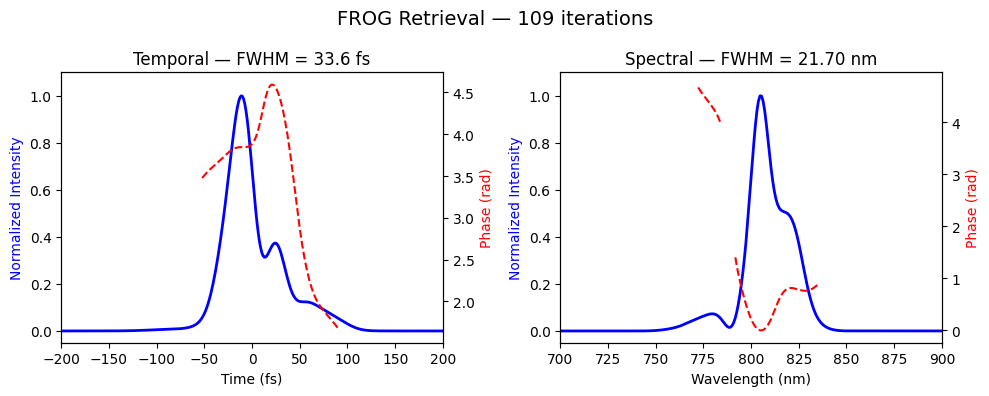

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bottom left: Temporal profile
ax_t = axes[0]
norm_t = result.temporal_intensity / result.temporal_intensity.max()
ax_t.plot(result.time, norm_t, 'b-', linewidth=2)
ax_t.set_xlabel('Time (fs)')
ax_t.set_ylabel('Normalized Intensity', color='b')
ax_t.set_ylim(-0.05, 1.1)
ax_t.set_xlim(-200,200)

ax_t2 = ax_t.twinx()
phase_t = result.temporal_phase.copy()
phase_t[norm_t < 0.05] = np.nan
ax_t2.plot(result.time, phase_t, 'r--', linewidth=1.5)
ax_t2.set_ylabel('Phase (rad)', color='r')
ax_t.set_title(f'Temporal — FWHM = {result.temporal_fwhm:.1f} fs')

# Bottom right: Spectral profile
ax_s = axes[1]
norm_s = result.spectral_intensity / result.spectral_intensity.max()
ax_s.plot(result.wavelength, norm_s, 'b-', linewidth=2)
ax_s.set_xlabel('Wavelength (nm)')
ax_s.set_ylabel('Normalized Intensity', color='b')
ax_s.set_ylim(-0.05, 1.1)
ax_s.set_xlim(700,900)

ax_s2 = ax_s.twinx()
phase_s = result.spectral_phase.copy()
phase_s[norm_s < 0.05] = np.nan
ax_s2.plot(result.wavelength, phase_s, 'r--', linewidth=1.5)
ax_s2.set_ylabel('Phase (rad)', color='r')
ax_s.set_title(f'Spectral — FWHM = {result.spectral_fwhm:.2f} nm')

fig.suptitle(f'FROG Retrieval — {result.num_iterations} iterations', fontsize=14)
fig.tight_layout()
plt.show()


While the above illustrates how to use the algorithm directly on preloaded images, the GrenouilleAnalyzer directly implements all of this inherently, making it plug and play with other aspects of GEECS-plugins (e.g. the Array2DAnalyzer to wrap and parallelize the analysis across all shots in a scan)

Note: if the file_path is added as an arg to auxiliary_data, the full trace data (intensit vs time, spectral phase vs wavlength, etc.) is dumped to a tsv file in the same location. When using the GrenouilleAnalyzer with the Array2DAnalyzer, the file_path passing already handled. These dumped 1D traces can be further processed using the existing 1D analyzers from ImageAnalysis.

To do: we will augment the GrenouilleAnalyzer to load the calibration factors and other control knobs for the algorithm directly from the config file. 

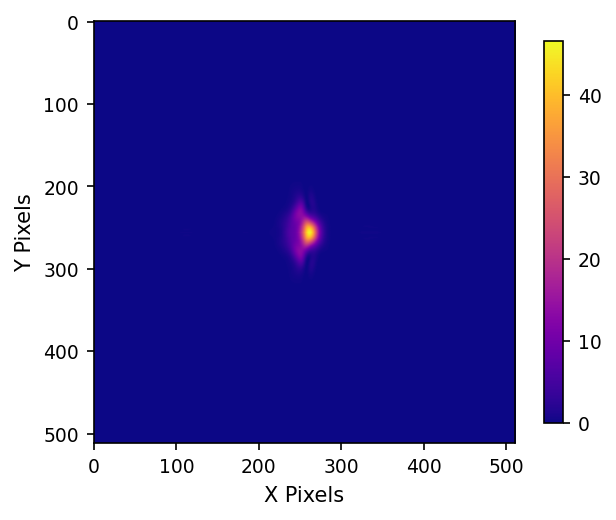

(<Figure size 600x600 with 2 Axes>,
 <Axes: xlabel='X Pixels', ylabel='Y Pixels'>)

In [6]:
from image_analysis.offline_analyzers.grenouille_analyzer import GrenouilleAnalyzer
from pathlib import Path
import numpy as np
dev_name = "U_FROG_Grenouille-Temporal"
file_path = Path('Z:/data/Undulator/Y2026/02-Feb/26_0210/scans/Scan015/U_FROG_Grenouille-Temporal/Scan015_U_FROG_Grenouille_010.png')
analyzer = GrenouilleAnalyzer(camera_config_name=dev_name)

res = analyzer.analyze_image_file(image_filepath=file_path, auxiliary_data={"file_path":str(file_path)})

analyzer.visualize(res)

see the 'basic_usage' example in the docs/scan_analysis/examples directories to see how to use this in scan analysis